In [1]:
import torch
from torch import nn
import torchvision
from torch.utils import data
import d2l.torch as d2l
import matplotlib.pyplot as plt
torch.set_default_tensor_type(torch.FloatTensor)

## 创建LeNet神经网络

因为这个网络是顺序的，直接用`nn.Sequential`就可以

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
x = torch.rand((1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    x: torch.Tensor = layer(x)
    print(layer.__class__.__name__, 'output shape: \t', x.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
batch_size = 256
trans = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='../data', train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../data', train=False, transform=trans, download=True
)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True)
test_iter = data.DataLoader(mnist_train, batch_size, shuffle=True)

In [5]:
x, y = next(iter(train_iter))
len(x), y.type(torch.float32)

(256,
 tensor([0., 4., 0., 2., 1., 0., 2., 7., 4., 2., 3., 2., 8., 0., 7., 0., 4., 3.,
         4., 5., 2., 4., 2., 4., 6., 5., 7., 3., 0., 5., 3., 2., 9., 6., 3., 3.,
         7., 1., 6., 5., 8., 3., 5., 1., 5., 2., 4., 9., 6., 0., 7., 7., 6., 4.,
         6., 3., 0., 6., 9., 8., 0., 6., 6., 9., 4., 9., 6., 0., 8., 9., 9., 7.,
         2., 1., 1., 7., 1., 0., 0., 2., 9., 9., 5., 5., 6., 2., 6., 3., 1., 5.,
         9., 3., 5., 4., 4., 0., 7., 5., 3., 2., 3., 0., 0., 0., 8., 1., 3., 5.,
         4., 0., 3., 2., 1., 7., 0., 1., 3., 5., 7., 6., 5., 7., 2., 8., 7., 7.,
         9., 3., 9., 5., 4., 1., 9., 9., 8., 9., 5., 8., 5., 3., 4., 0., 8., 9.,
         6., 4., 6., 1., 0., 4., 7., 4., 2., 0., 6., 7., 3., 7., 3., 5., 3., 6.,
         6., 6., 4., 6., 3., 5., 0., 4., 3., 3., 7., 8., 7., 8., 1., 6., 5., 0.,
         6., 4., 8., 0., 8., 9., 9., 6., 2., 2., 0., 3., 2., 3., 1., 5., 0., 0.,
         6., 0., 0., 7., 1., 2., 7., 5., 2., 2., 1., 6., 7., 2., 4., 2., 9., 8.,
         9., 0., 6., 9

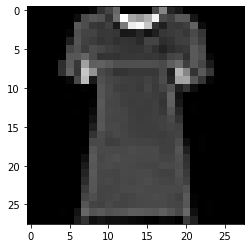

In [6]:
plt.imshow(x[0].reshape(28, 28), cmap='gray')

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for x, y in data_iter:
            if isinstance(x, list):
                x = [x_.to(device) for x_ in x]
            else:
                x = x.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]

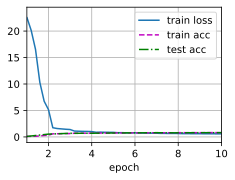

In [8]:
lr = 0.9
num_epochs = 10
device = d2l.try_gpu()

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
print('training on', device)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
animator = d2l.Animator(
    xlabel='epoch',
    xlim=[1, num_epochs],
    legend=['train loss', 'train acc', 'test acc']
)
num_batches = len(train_iter)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (x, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_hat = net(x)
        # print(y, y.shape)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        with torch.no_grad():
            metric.add(l * x.shape[0], d2l.accuracy(y_hat, y), x.shape[0])
        train_l = metric[0] / metric[1]
        train_acc = metric[1] / metric[2]
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches,
                (train_l, train_acc, None)
            )
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))

In [9]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # print(y, y.shape)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


loss 0.470, train acc 0.823, test acc 0.821
33381.8 examples/sec on cuda:0


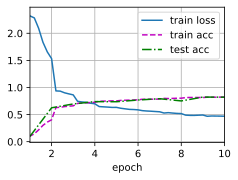

In [10]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
